In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, TensorDataset, DataLoader, Subset
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torchvision.transforms as T


import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.conv_models import ConvModelMNIST
from models.train_test import *
from prunning_methods.LTH import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def build_loaders(data_dir: str, batch_size: int, device: torch.device, 
                  fim_size: int = 5000, seed: int = 42):
# CIFAR-10 stats
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    
    
    train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
    ])
    
    
    test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
    ])
    
    
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_tf)
    test_set = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_tf)

    num_classes = 10
    assert fim_size % num_classes == 0, \
        f"fim_size ({fim_size}) must be divisible by num_classes ({num_classes})"

    per_class = fim_size // num_classes

    targets = torch.tensor(train_set.targets)  # shape: [50000]
    g = torch.Generator().manual_seed(seed)
    
    indices_per_class = []
    for c in range(num_classes):
        class_idx = torch.nonzero(targets == c).view(-1)  # indices of samples of class c
        # shuffle indices for this class
        perm = class_idx[torch.randperm(len(class_idx), generator=g)]
        # take per_class samples
        indices_per_class.append(perm[:per_class])

    # concatenate all class indices and shuffle globally
    balanced_indices = torch.cat(indices_per_class)
    balanced_indices = balanced_indices[torch.randperm(len(balanced_indices), generator=g)]

    fim_subset = Subset(train_set, balanced_indices.tolist())
    
    train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
    )

    fim_loader = DataLoader(
    fim_subset,
    batch_size=1,
    shuffle=True
    )
    
    test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False
    )
    
    return train_loader, fim_loader, test_loader

In [4]:
train_loader, fim_loader, test_loader = build_loaders('./data', 1028, device)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
len(fim_loader)

5000

In [6]:
model = torchvision.models.mobilenet_v3_small(num_classes=10)
for name, param in model.named_parameters():
    print(name, param.numel())

features.0.0.weight 432
features.0.1.weight 16
features.0.1.bias 16
features.1.block.0.0.weight 144
features.1.block.0.1.weight 16
features.1.block.0.1.bias 16
features.1.block.1.fc1.weight 128
features.1.block.1.fc1.bias 8
features.1.block.1.fc2.weight 128
features.1.block.1.fc2.bias 16
features.1.block.2.0.weight 256
features.1.block.2.1.weight 16
features.1.block.2.1.bias 16
features.2.block.0.0.weight 1152
features.2.block.0.1.weight 72
features.2.block.0.1.bias 72
features.2.block.1.0.weight 648
features.2.block.1.1.weight 72
features.2.block.1.1.bias 72
features.2.block.2.0.weight 1728
features.2.block.2.1.weight 24
features.2.block.2.1.bias 24
features.3.block.0.0.weight 2112
features.3.block.0.1.weight 88
features.3.block.0.1.bias 88
features.3.block.1.0.weight 792
features.3.block.1.1.weight 88
features.3.block.1.1.bias 88
features.3.block.2.0.weight 2112
features.3.block.2.1.weight 24
features.3.block.2.1.bias 24
features.4.block.0.0.weight 2304
features.4.block.0.1.weight 96

In [7]:
def mobilenet_cifar(num_classes: int = 10) -> nn.Module:
    model = torchvision.models.mobilenet_v3_small(num_classes=num_classes)
    # Replace the 7x7 stride-2 conv + maxpool with a 3x3 stride-1 conv and no pool
    #model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    #model.maxpool = nn.Identity()
    return model
#print(f"mobilenet tem {sum([p.numel() for p in mobilenet_cifar().parameters()])} parametros")

In [27]:
fim_args = {"complete_fim": False, 
            "layers":  ['features.1.block.1.fc1.weight', 'features.3.block.0.0.weight'], 
            "mask":  None, 
            "sampling_type":  'complete', 
            "sampling_frequency":  (9,9)
            }


LTH_args = {"model": mobilenet_cifar().to(device), 
            "criterion": nn.CrossEntropyLoss(), 
            "train_loader": train_loader, 
            "test_loader": test_loader, 
            "fim_loader": fim_loader, 
            "fim_args": fim_args, 
            "lr" : 1e-3,
            "n_iterations":5, 
            "n_epochs":60, 
            "prunning_percentage":0.20, 
            "no_prunning_layers":None, 
            "verbose":True,
            "print_freq":10, 
            "use_scheduler":False, 
            "save_path":None
            }
           

In [28]:
output_dict = train_LTH(**LTH_args)

LTH Iteration 1/5
Epoch 1/60- Loss: 1.7700222730636597
Epoch 11/60- Loss: 1.3187339305877686
Epoch 21/60- Loss: 1.0323026180267334
Epoch 31/60- Loss: 0.9452254772186279
Epoch 41/60- Loss: 0.8994826078414917
Epoch 51/60- Loss: 0.8226122260093689
Test Accuracy after iteration 1: 67.84%
LTH Iteration 2/5
Epoch 1/60- Loss: 2.3026492595672607
Epoch 11/60- Loss: 2.302499771118164
Epoch 21/60- Loss: 2.3024697303771973
Epoch 31/60- Loss: 2.302661418914795
Epoch 41/60- Loss: 2.302692413330078
Epoch 51/60- Loss: 2.301382064819336
Test Accuracy after iteration 2: 10.00%
LTH Iteration 3/5
Epoch 1/60- Loss: 2.302333116531372
Epoch 11/60- Loss: 2.3028526306152344
Epoch 21/60- Loss: 2.3025357723236084
Epoch 31/60- Loss: 2.303267240524292
Epoch 41/60- Loss: 2.3020997047424316
Epoch 51/60- Loss: 2.3025741577148438
Test Accuracy after iteration 3: 10.00%
LTH Iteration 4/5
Epoch 1/60- Loss: 2.3023624420166016
Epoch 11/60- Loss: 2.3024864196777344
Epoch 21/60- Loss: 2.302424430847168
Epoch 31/60- Loss: 2.

In [29]:
output_dict["mask_list"][-1]

{'features.0.0.weight': tensor([[[[1., 0., 0.],
           [0., 0., 0.],
           [1., 0., 0.]],
 
          [[0., 1., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 1.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 1.]],
 
          [[0., 1., 0.],
           [0., 0., 0.],
           [0., 1., 0.]],
 
          [[0., 0., 0.],
           [1., 1., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [1., 1., 1.],
           [0., 0., 1.]],
 
          [[1., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 1., 1.],
           [0., 0., 0.],
           [1., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 1., 1.],
           [1., 0., 0.],
           [0., 1., 0.]]],
 
 
         [[[1., 0., 0.],
    

In [30]:
output_dict['fim_list'][0].fim['features.1.block.1.fc1.weight']

tensor([[ 1.3191e-02,  2.1508e-02,  9.5627e-03,  ..., -4.6632e-05,
         -8.8033e-05, -1.0257e-04],
        [ 2.1508e-02,  4.5620e-02,  1.9439e-02,  ..., -1.8678e-04,
         -2.9087e-04, -3.6478e-04],
        [ 9.5627e-03,  1.9439e-02,  1.3504e-02,  ..., -1.0796e-04,
         -1.8090e-04, -1.9176e-04],
        ...,
        [-4.6632e-05, -1.8678e-04, -1.0796e-04,  ...,  4.8648e-04,
          5.0174e-04,  7.0067e-04],
        [-8.8033e-05, -2.9087e-04, -1.8090e-04,  ...,  5.0174e-04,
          8.0906e-04,  9.0281e-04],
        [-1.0257e-04, -3.6478e-04, -1.9176e-04,  ...,  7.0067e-04,
          9.0281e-04,  1.2878e-03]])

In [31]:
for i in range(len(output_dict['fim_list'])):
    print(output_dict['fim_list'][i].fim['features.1.block.1.fc1.weight'].shape, output_dict['fim_list'][i].logdet_ratio)

torch.Size([128, 128]) {'features.1.block.1.fc1.weight': 285.055908203125, 'features.3.block.0.0.weight': 4916.052734375}
torch.Size([128, 128]) {'features.1.block.1.fc1.weight': 0.0, 'features.3.block.0.0.weight': 0.0}
torch.Size([128, 128]) {'features.1.block.1.fc1.weight': 0.0, 'features.3.block.0.0.weight': 0.0}
torch.Size([128, 128]) {'features.1.block.1.fc1.weight': 0.0, 'features.3.block.0.0.weight': 0.0}
torch.Size([128, 128]) {'features.1.block.1.fc1.weight': 0.0, 'features.3.block.0.0.weight': 0.0}


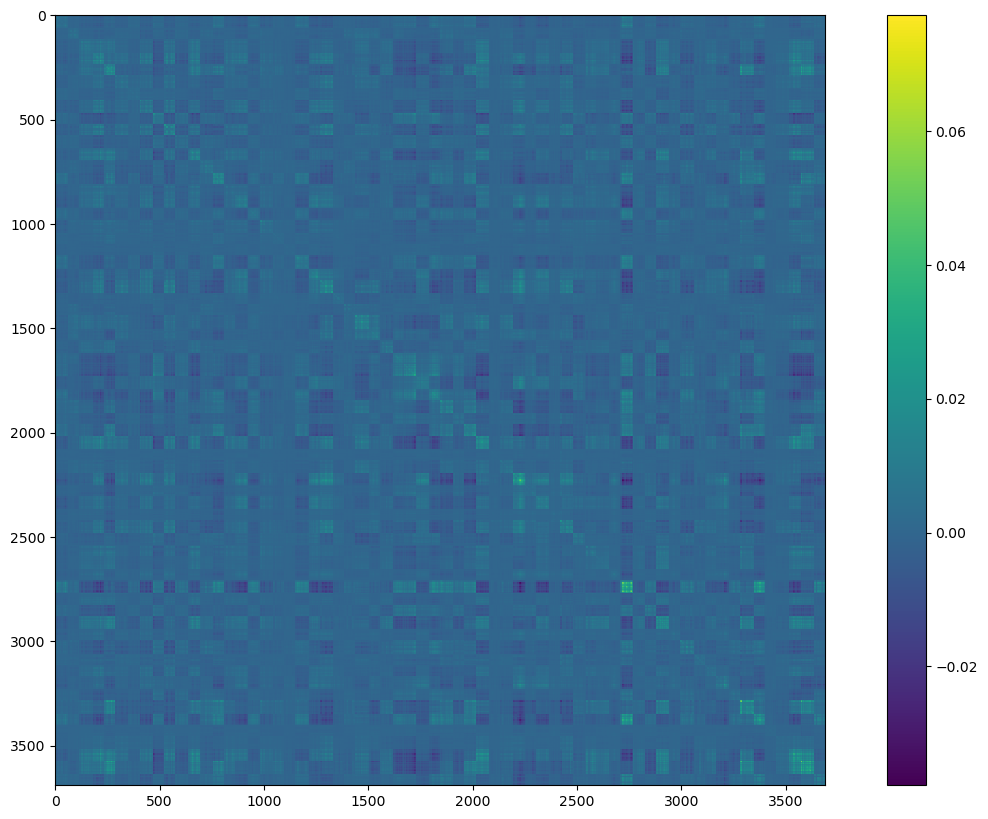

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
fim = ax.imshow(output_dict['fim_list'][0].fim['layer1.1.conv1.weight'].cpu().numpy(), interpolation='nearest')
fig.colorbar(fim, orientation='vertical')

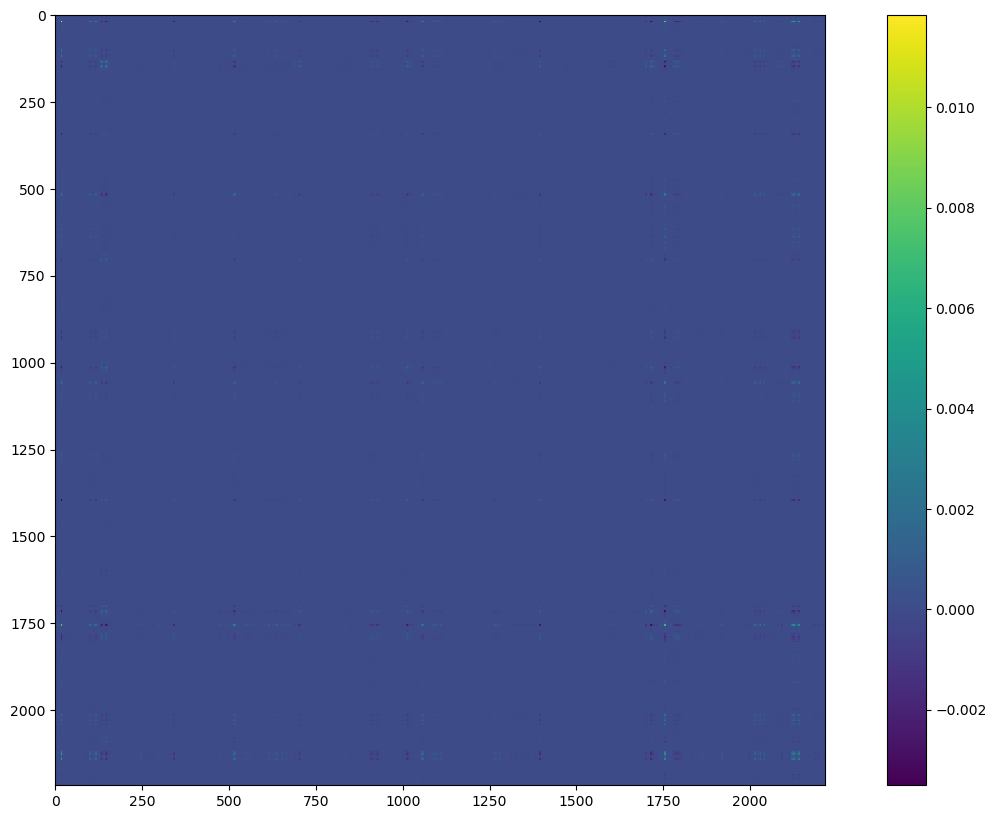

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,10))
fim = ax.imshow(output_dict['fim_list'][-1].fim['layer1.1.conv1.weight'].cpu().numpy(), interpolation='nearest')
fig.colorbar(fim, orientation='vertical')